In [1]:
# Necessary imports
import pandas as pd
import os
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# Load the data

df = pd.DataFrame()
base_dir = 'Meiro Mobility_ML Assignment Dataset_Jan2022Jul2023'
for file in os.listdir(base_dir):
    df_ = pd.read_json(f'{base_dir}/{file}')
    df = pd.concat([df, df_])

df.head()

,driverId,tripId,startLocation,tripDistance,tripSpeed,tripDuration,endLocation,startTime,tripFare,paymentType,endTime
0,1,0,"[22.93559, 72.582335]",9.9,15.68,38,"[22.98658, 72.661468]",2023-03-01T18:29:00,105,upi,2023-03-01T19:06:00
1,1,1,"[23.008735, 72.569544]",6.0,20.72,17,"[23.008724, 72.628318]",2023-03-01T20:54:00,66,upi,2023-03-01T21:11:00
2,1,2,"[22.939357, 72.489064]",8.2,15.34,32,"[22.976431, 72.55884]",2023-03-01T22:17:00,88,upi,2023-03-01T22:49:00
3,1,3,"[22.977032, 72.64413]",4.1,16.57,15,"[23.007479, 72.667293]",2023-03-01T22:48:00,47,upi,2023-03-01T23:02:00
4,1,4,"[22.978932, 72.529229]",11.0,23.71,28,"[23.060032, 72.590956]",2023-03-02T21:23:00,116,cash,2023-03-02T21:50:00


<Axes: xlabel='weekday', ylabel='hour'>

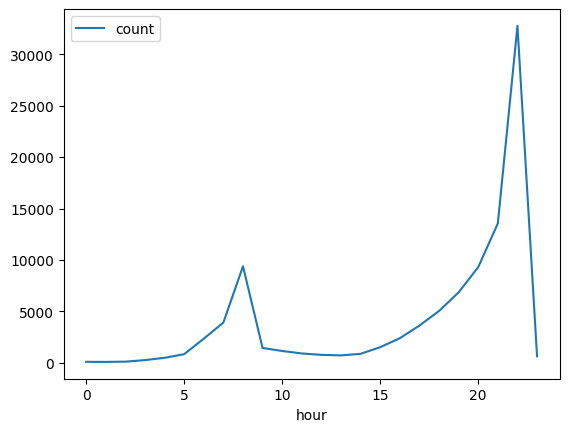

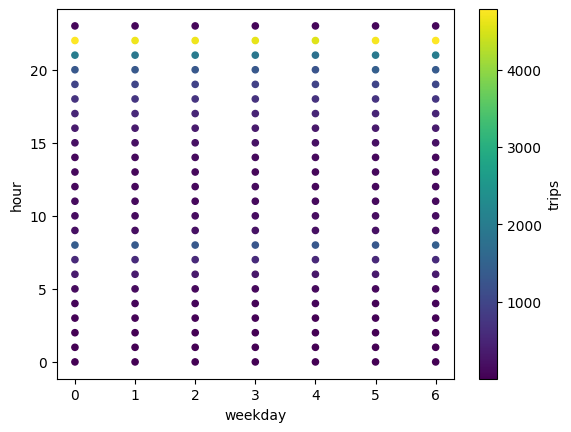

In [3]:
# Feature engineering
df['startTime'] = pd.to_datetime(df['startTime'])
df['weekday'] = df['startTime'].dt.dayofweek
df['hour'] = df['startTime'].dt.hour

df.groupby('hour')['tripId'].count().reset_index().rename(columns={'tripId':'count'}).sort_index().plot.line('hour','count')
df.groupby(['weekday','hour'])['tripId'].count().reset_index().rename(columns={'tripId':'trips'}).plot.scatter('weekday', 'hour', c='trips', colormap='viridis')

In [4]:
df.set_index('startTime', inplace=True)
df.sort_index(inplace=True)

# Aggregating data by 15 minute interval
df_i15 = df.resample('15T').agg({'tripId': 'count'})

df_i15['hour'] = df_i15.index.hour
df_i15['weekday'] = df_i15.index.day_name()

# train test split
train_size = int(len(df_i15) * 0.8)
train, test = df_i15[:train_size], df_i15[train_size:]

MAE arima: 3.2135117769974304


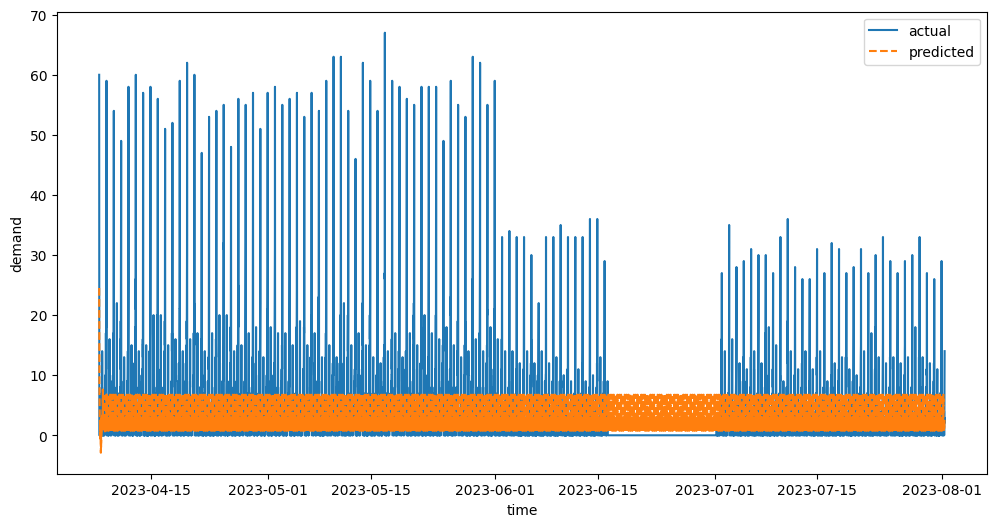

In [6]:
## ARIMA
arima_model = SARIMAX(train['tripId'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
arima_results = arima_model.fit(disp=False)
arima_predictions = arima_results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Evaluate the Model
mae = mean_absolute_error(test['tripId'], arima_predictions)
print(f'MAE arima: {mae}')

# Visualize the Results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['tripId'], label='actual')
plt.plot(test.index, arima_predictions, label='predicted', linestyle='--')
plt.xlabel('time')
plt.ylabel('demand')
plt.legend()
plt.show()

MAE XGB: 2.1787295112790277


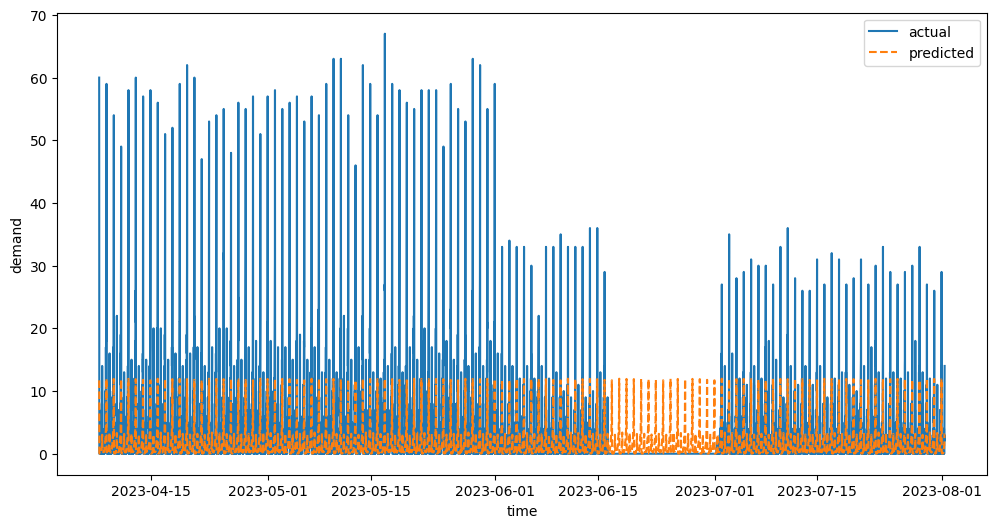

In [7]:
## XGBoost
# Encoding
df_i15_2 = pd.get_dummies(df_i15, columns=['weekday'], drop_first=True)

# Train-Test Split
train_size = int(len(df_i15) * 0.8)
train, test = df_i15_2[:train_size], df_i15_2[train_size:]

xgb_model = XGBRegressor()
xgb_model.fit(train[['hour', 'weekday_Monday', 'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday', 'weekday_Saturday', 'weekday_Sunday']], train['tripId'])
xgb_predictions = xgb_model.predict(test[['hour', 'weekday_Monday', 'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday', 'weekday_Saturday', 'weekday_Sunday']])

# Evaluate
mae = mean_absolute_error(test['tripId'], xgb_predictions)
print(f'MAE XGB: {mae}')

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['tripId'], label='actual')
plt.plot(test.index, xgb_predictions, label='predicted', linestyle='--')
plt.xlabel('time')
plt.ylabel('demand')
plt.legend()
plt.show()